In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import pandas as pd
from pathlib import Path
from utils import *
from inception import *
from models import *
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import fastai
from fastai.vision import *

In [3]:
DATAPATH = Path.cwd()

In [4]:
sorted(list(DATAPATH.iterdir()))

[PosixPath('/home/tc256760/Documents/TimeSeries_fastai/.git'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/.gitignore'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/.ipynb_checkpoints'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/.vscode'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/01_adiac-LBFGS-Copy1.ipynb'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/01_adiac-LBFGS.ipynb'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/01_adiac-inception.ipynb'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/01_adiac.ipynb'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/02_adiac_inception_resnet.ipynb'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Adiac'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/README.md'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/__pycache__'),
 PosixPath('/home/tc256760/Documents/Ti

In [5]:
task = 'Adiac'
df_train, df_test = load_df(DATAPATH, task)

In [6]:
num_classes = df_train.target.nunique(); num_classes

37

In [7]:
def process_dfs(df_train, df_test):
    x_train, y_train = df_train.values[:,:-1].astype('float'), df_train.values[:,-1].astype('int')
    x_test, y_test = df_test.values[:,:-1].astype('float'), df_test.values[:,-1].astype('int')

    x_train_mean = x_train.mean()
    x_train_std = x_train.std()

    x_train = (x_train - x_train_mean)/(x_train_std)
    x_test = (x_test - x_train_mean)/(x_train_std)

    y_train = (y_train - y_train.min())/(y_train.max()-y_train.min())*(num_classes-1)
    y_test = (y_test - y_test.min())/(y_test.max()-y_test.min())*(num_classes-1)
    return x_train, y_train, x_test, y_test

# DL

In [8]:
def to_TDS(x, y):
    return TensorDataset(torch.Tensor(x).unsqueeze(dim=1),  torch.Tensor(y).long())

def create_databunch(tr_ds, val_ds, bs=64):
    train_dl = DataLoader(tr_ds, batch_size=bs, shuffle=True)
    valid_dl = DataLoader(val_ds, batch_size=bs, shuffle=True)
    return DataBunch(train_dl, valid_dl)

In [9]:
x_train, y_train, x_test, y_test = process_dfs(df_train, df_test)

In [10]:
x_train.shape, x_test.shape

((390, 176), (391, 176))

In [11]:
tr_ds, val_ds = to_TDS(x_train, y_train), to_TDS(x_test, y_test)

In [12]:
db = create_databunch(tr_ds, val_ds, 8)

Testing dims at input/output

In [13]:
tx, ty = next(iter(db.train_dl))

In [14]:
tx.shape, ty.shape

(torch.Size([8, 1, 176]), torch.Size([8]))

## Inception Time

In [15]:
model = create_inception(1, num_classes)

In [16]:
# model = create_inception_resnet(1, num_classes, kss=[3,5,7], conv_sizes=[64, 128, 256], stride=1)

In [17]:
model

SequentialEx(
  (layers): ModuleList(
    (0): InceptionModule(
      (conv1): Conv1d(1, 32, kernel_size=(41,), stride=(1,), padding=(20,), bias=False)
      (conv2): Conv1d(1, 32, kernel_size=(21,), stride=(1,), padding=(10,), bias=False)
      (conv3): Conv1d(1, 32, kernel_size=(11,), stride=(1,), padding=(5,), bias=False)
      (conv_bottle): Sequential(
        (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
        (1): Conv1d(1, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
      (bn_relu): Sequential(
        (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
      )
    )
    (1): Shortcut(
      (act_fn): ReLU(inplace=True)
      (conv): Conv1d(1, 128, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): InceptionModule(
      (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,),

In [18]:
model.cuda()(tx).shape

torch.Size([8, 37])

In [19]:
learn_res = fastai.basic_train.Learner(db, 
                                       model, 
                                       loss_func = CrossEntropyFlat(), 
                                       metrics=[error_rate],
                                       wd=1e-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


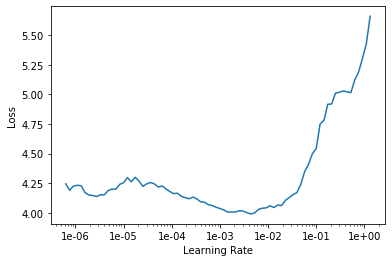

In [20]:
learn_res.lr_find(); learn_res.recorder.plot()

In [21]:
learn_res.fit_one_cycle(40, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,3.906255,3.839843,0.946292,00:01
1,3.684939,3.664242,0.946292,00:01
2,3.543426,3.563109,0.905371,00:01
3,3.417567,3.516505,0.884910,00:01
4,3.329496,3.525489,0.900256,00:01
5,3.173949,3.257397,0.869565,00:01
6,3.028749,3.030341,0.805627,00:00
7,2.896987,2.984328,0.810742,00:00
8,2.725621,3.023877,0.820972,00:00
9,2.623393,2.863238,0.823529,00:00


In [22]:
p, t = learn_res.get_preds()

In [23]:
error_rate(p,t)

tensor(0.3862)

In [24]:
def get_cm(p, t): return confusion_matrix(t, p.softmax(dim=1).argmax(1))

Confusion Matrix

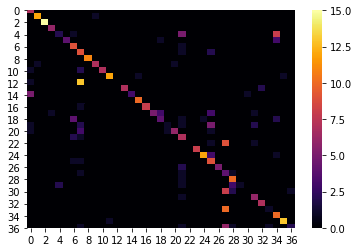

In [25]:
sns.heatmap(get_cm(p,t), cmap='inferno')